In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm
from collections import defaultdict

plt.rcParams['figure.figsize'] = (10, 6)

## Время - деньги

Проведение эксперимента затратно как само по себе, так и имеет косвенные затраты:
- **Сопутствующие затраты.** Если мы проводим какую-нибудь промо-акцию, то на её организацию требуются дополнительные ресурсы.
- **Можем отпугнуть пользователей.** Если эксперимент вредит пользователям, то мы потеряем их лояльность.
- **Упущенная выгода.** Если есть положительный эффект, то каждый день пока мы откладываем внедрение создает упущенную выгоду.
        
Естественное желание: завершить эксперимент как можно раньше.

# 1. Peeking problem

Принятие решения в конце эксперимента согласно дизайну гарантирует получение результата с заданными вероятностями ошибок. Проверим что будет, если проверять значимость отличий во время эксперимента.

In [2]:
def test_sequential_simple(a, b, alpha=0.05, min_size=5):
    """Проводим последовательное тестирование.
    
    a, b - данные контрольной и экспериментальной групп
    alpha - уровень значимости
    min_size - минимальный размер групп, с которого начинается проверка гипотезы

    return:
        pvalues - массив значений pvalue размером len(a)-min_size+1
        test_decision (bool) - наличие статистически значимого эффекта по всем данным
        seq_test_decision (bool) - наличие статистически значимого эффекта при последовательном тесте
    """
    pvalues = []
    for size in range(min_size, len(a)+1):
        a_ = a[:size]
        b_ = b[:size]
        pvalue = stats.ttest_ind(a_, b_).pvalue
        pvalues.append(pvalue)
    pvalues = np.array(pvalues)
    test_decision = pvalues[-1] < alpha
    seq_test_decision = np.any(pvalues < alpha)
    return pvalues, test_decision, seq_test_decision

Сравним количество ошибок первого рода при тестировании с подглядыванием и без подглядывания.

In [3]:
sample_size = 100
alpha = 0.05
min_size = 20

res = []
for _ in tqdm(range(100)):
    a, b = np.random.normal(0, 1, (2, sample_size))
    res.append(test_sequential_simple(a, b, alpha, min_size))

list_test_decision = [x[1] for x in res]
list_seq_test_decision = [x[2] for x in res]

print('Количество ошибок первого рода:')
print('Без подглядываний:', np.sum(list_test_decision))
print('С подглядываниями:', np.sum(list_seq_test_decision))

  0%|          | 0/100 [00:00<?, ?it/s]

Количество ошибок первого рода:
Без подглядываний: 4
С подглядываниями: 22


Вероятность ошибки I рода увеличилась. При последовательном тестировании нулевая гипотеза отклоняется чаще, по сравнению с проведением теста один раз в конце.

Построим графики значений pvalue в зависимости от объёма данных.

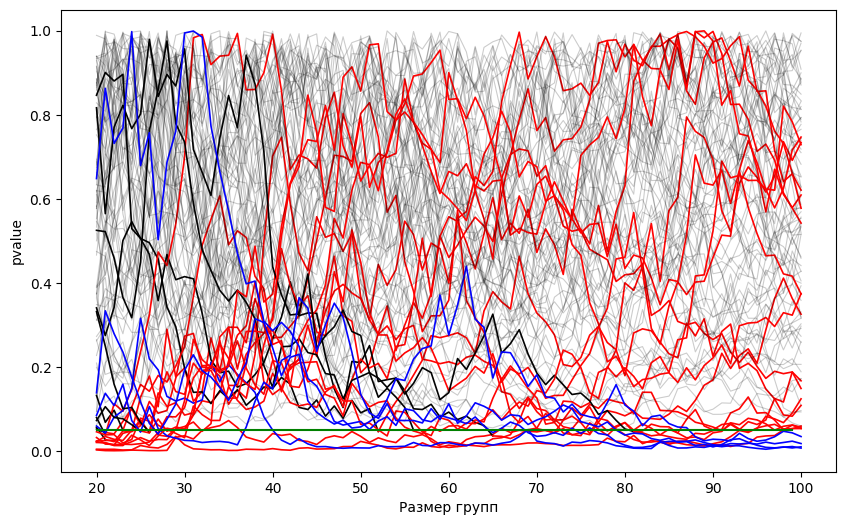

In [4]:
for pvalues, test_decision, seq_test_decision in res:
    len_ = len(pvalues)
    X = np.arange(min_size, min_size+len_)
    if not seq_test_decision:
        plt.plot(X, pvalues, linewidth=0.8, color='k', alpha=0.2)
        continue
    if test_decision:
        plt.plot(X, pvalues, linewidth=1.2, color='b', alpha=0.99)
        continue
    first_red_point = np.arange(len_)[pvalues < alpha][0]
    mask_r = np.arange(len_) >= first_red_point
    mask_b = np.arange(len_) <= first_red_point
    Y = pvalues
    plt.plot(X[mask_b], pvalues[mask_b], linewidth=1.2, color='k', alpha=0.99)
    plt.plot(X[mask_r], pvalues[mask_r], linewidth=1.2, color='r', alpha=0.99)

plt.plot([min_size, sample_size-1], [alpha, alpha], 'g')
plt.xlabel('Размер групп')
plt.ylabel('pvalue')
plt.show()

- зелёная линия - граница уровня значимости 0.05
- серые - не разу не получили значимые отличия
- синий - значимые отличия на всех данных
- чёрный переходящий в красный - на всех данных отличия не значимые, но были значимые результаты в течение эксперимента

**Подглядывание увеличивает вероятность ошибки 1 рода**

# 2. Критерий Вальда

Хотим иметь возможность раньше остановить тест и принять решение при наличии сильных отклонений.
</br>При этом вероятность ошибки первого рода должна контролироваться.

### Критерий Вальда

Пусть $X_i$ - СВ $X\sim F(x | \theta)$ в $i$-ом испытании, $i=1, 2, \ldots$
    
Гипотезы: $H_0: \theta=\theta_0$, $H_1: \theta=\theta_1$

Отношение правдоподобий для первых $n$ испытаний
$$\Lambda_T
= \frac{L(X_1,\ldots,X_n; \theta_1)}{L(X_1,\ldots, X_n; \theta_0)}
= \frac{\prod_{i=1}^n f (X_i | \theta_1)}{\prod_{i=1}^n f (X_i | \theta_0)}$$

**Правило принятия решения:**

Зададим положительные константы $A < 1 < B$.
- если $\Lambda_T > B$, отклоняем $H_0$ и останавливаемся;
- если $\Lambda_T < A$, отклоняем $H_1$ и останавливаемся;
- иначе продолжаем собирать данные.

### Теорема о сходимости

Не может ли блуждание $\Lambda_T$ между $A$ и $B$ продолжаться бесконечно долго?

#### Теорема
Критерий Вальда с вероятностью 1 заканчивается за конечное число шагов, то есть
    $$\lim_{n\to\infty} \mathbb{P}(\nu > n | \theta_i)=0, \qquad i=\{0, 1\}$$
    где $\nu$ - количество испытаний до момента остановки.
    
### Выбор границ

#### Теорема
Границы $A$ и $B$ критерия Вальда силы $(\alpha, ~ \beta)$ удовлетворяют неравенствам
$$A \geq A^* = \frac{\beta}{1-\alpha}, \qquad B \leq B^* = \frac{1-\beta}{\alpha}$$
при этом, если границы $A$ и $B$ заменить их оценками $A^*$ и $B^*$, то сила полученного критерия будет равна $(\alpha^*, ~ \beta^*)$, где
$$\alpha^* \leq \frac{\alpha}{1-\beta}, \qquad \beta^* \leq \frac{\beta}{1-\alpha} \qquad и \qquad \alpha^* + \beta^* \leq \alpha + \beta .$$


### Границы для гипотезы о равенстве средних

$X_1,\ldots,X_n\sim N(\mu_1, \sigma^2)$, $Y_1,\ldots,Y_n\sim N(\mu_2, \sigma^2)$.

Гипотезы: $H_0 : \mu_2 - \mu_1 = 0$, $H_1 : \mu_2 - \mu_1 = \theta_1 > 0$.


Разница случайных величин: $Y - X \sim N(\theta, 2\sigma^2)$, где $\theta = \mu_2 - \mu_1$.

Логарифм отношения правдоподобий
$$\ln\Lambda = \ln\frac{ \prod_{i=1}^n \exp \left( -\frac{(y_i - x_i - \theta_1)^2}{4\sigma^2} \right) }{ \prod_{i=1}^n \exp \left( -\frac{(y_i - x_i)^2}{4\sigma^2} \right) }
= \sum_{i=1}^n \frac{2\theta_1 (y_i - x_i) - \theta_1^2}{4\sigma^2} 
% = \frac{n\theta_1}{2\sigma^2} (\overline{Y^n} - \overline{X^n}) - \frac{n \theta_1^2}{4 \sigma^2}
= \frac{n\theta_1}{2\sigma^2} \left( (\overline{Y^n} - \overline{X^n}) - \frac{\theta_1}{2} \right)$$
Границы критерия Вальда: $\ln A < \ln \Lambda < \ln B$.

Обозначим $\hat{\theta} = \overline{Y^n} - \overline{X^n}$, тогда
$$\frac{2\sigma^2}{\theta_1} \ln A < n\left(\hat{\theta} - \frac{\theta_1}{2}\right) < \frac{2\sigma^2}{\theta_1} \ln B$$
где $A \approx \dfrac{\beta}{1-\alpha}, ~ B \approx \dfrac{1-\beta}{\alpha}$.




## 2.1. Реализация критерия Вальда для данных нормального распределения

In [5]:
def test_sequential_wald_norm(a, b, std, effect, alpha, beta):
    """Проводим последовательное тестирование критерием Вальда для данных нормального р-ния.

    a, b - данные контрольной и экспериментальной групп
    std - стандартное отклонение
    effect - размер эффекта
    alpha, beta - допустимые вероятности ошибок первого и второго рода

    return:
        - decision: 0 - незначимые отличия, 1 - значимые отличия, 0.5 - границы не пересечены
        - values - значения статистики
    """
    coef = 2 * std ** 2 / effect
    lower_bound = coef * np.log(beta / (1 - alpha))
    upper_bound = coef * np.log((1 - beta) / alpha)
    values = []
    for n in range(1, len(a) + 1):
        delta_mean = np.mean(b[:n]) - np.mean(a[:n])
        value = n * (delta_mean - effect / 2)
        values.append(value)
        if value < lower_bound:
            return 0, values
        if value > upper_bound:
            return 1, values
    return 0.5, values

#### Построим визуализацию с траекториями статистики критерия Вальда

Дополнительно построим границы критерия Стьюдента, положив дисперсию данных равной $\sigma^2$.

Статистика критерия:

$$ \dfrac{\hat{\theta}}{\sigma \sqrt{2/n}} \sim St(\nu) , \quad \nu = 2 (n-1) $$

Преобразуем:
$$ n \left(\hat{\theta} - \dfrac{\theta_1}{2}\right) \sim n \left({\sigma \sqrt{2/n}}\ St(\nu) - \dfrac{\theta_1}{2} \right) $$

In [6]:
def get_sample_size(std, eff, alpha, beta):
    t_alpha = stats.norm.ppf(1 - alpha / 2)
    t_beta = stats.norm.ppf(1 - beta)
    disp_sum = 2 * (std ** 2)
    sample_size = int(
        np.ceil(
            (t_alpha + t_beta) ** 2 * disp_sum / eff ** 2
        )
    )
    return sample_size

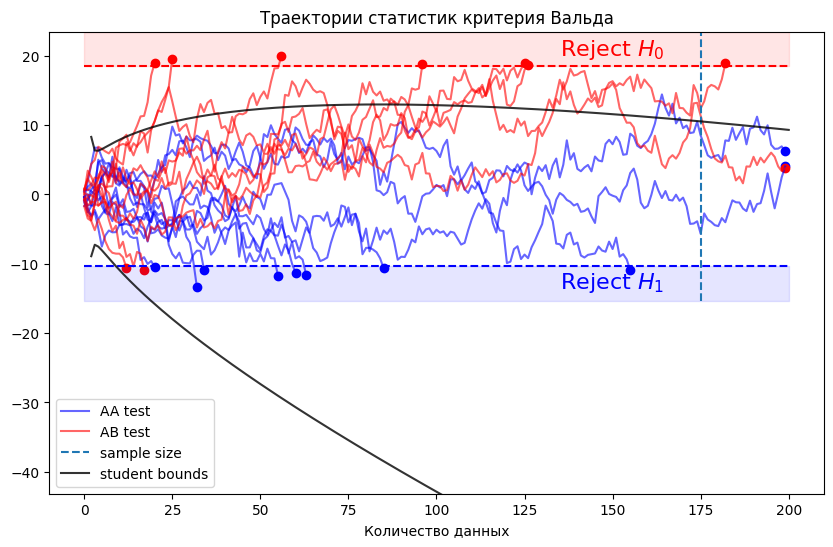

In [8]:
ALPHA = 0.05
BETA = 0.2
MEAN = 10
STD = 1
EFFECT = 0.3
sample_size = get_sample_size(STD, EFFECT, ALPHA, BETA)
sample_size_ = 200

# имитируем эксперименты
list_curve_aa = []
list_curve_ab = []
for _ in range(10):
    a_one, a_two = np.random.normal(MEAN, STD, (2, sample_size_))
    b = np.random.normal(MEAN + EFFECT, STD, sample_size_)
    _, values_aa = test_sequential_wald_norm(a_one, a_two, STD, EFFECT, ALPHA, BETA)
    _, values_ab = test_sequential_wald_norm(a_one, b, STD, EFFECT, ALPHA, BETA)
    list_curve_aa.append(values_aa)
    list_curve_ab.append(values_ab)

# строим кривые статистики Вальда
curves = [
    [list_curve_aa, 'b', 'AA test'],
    [list_curve_ab, 'r', 'AB test'],
]
for list_curve, color, label in curves:
    for idx, curve in enumerate(list_curve):
        plt.plot(
            np.arange(len(curve)),
            curve,
            color,
            label=label if idx==0 else '',
            alpha=0.6
        )
        plt.scatter([len(curve) - 1], curve[-1], color=color)

# отображаем границы критерия Вальда
coef = 2 * STD ** 2 / EFFECT
lower_bound = coef * np.log(BETA / (1 - ALPHA))
upper_bound = coef * np.log((1 - BETA) / ALPHA)
plt.hlines(upper_bound, 0, sample_size_, color='r', linestyle='--')
plt.hlines(lower_bound, 0, sample_size_, color='b', linestyle='--')
plt.fill_between(
    np.arange(sample_size_ + 1), upper_bound, upper_bound + 5,
    color='r', alpha=0.1
)
plt.fill_between(
    np.arange(sample_size_ + 1), lower_bound, lower_bound - 5,
    color='b', alpha=0.1
)
plt.vlines(
    sample_size, lower_bound - 5, upper_bound + 5,
    linestyle='--', label='sample size'
)
plt.text(135, 20, 'Reject $H_0$', color='r', size=16)
plt.text(135, -13.5, 'Reject $H_1$', color='b', size=16)

# Строим границы критерия Стьюдента
lower_bounds_student, upper_bounds_student = [], []
array_size = np.arange(2, sample_size_ + 1)
for size in array_size:
    std_delta_mean = (2 / size) ** 0.5 * STD
    student_nu = 2 * (size - 1)
    bounds = (std_delta_mean * stats.t.ppf([ALPHA/2, 1-ALPHA/2], df=student_nu) - EFFECT/2) * size
    lower_bounds_student.append(bounds[0])
    upper_bounds_student.append(bounds[1])
plt.plot(array_size, lower_bounds_student, '-k', alpha=0.8)
plt.plot(array_size, upper_bounds_student, '-k', label='student bounds', alpha=0.8)

plt.ylim([np.median(lower_bounds_student), upper_bound+5])
plt.xlabel('Количество данных')
plt.title('Траектории статистик критерия Вальда')
plt.legend()
plt.show()

Замечание: в экспериментах с эффектом ошибок в среднем больше, так как $\beta > \alpha$.

Иллюстрация выше показывает как работает критерий Вальда: тест останавливается, когда статистика выходит за границу, и принимается соответствующее решение.


## 2.2. Проверка корректности критерия Вальда

Оценим вероятности ошибок первого и второго рода критерия Вальда. Проведём синтетически АА и АБ тесты.

In [9]:
def pdf_a(x):
    """Функция плотности разницы средних при верности нулевой гипотезы."""
    return stats.norm.pdf(x, 0, np.sqrt(2) * STD)

def pdf_b(x):
    """Функция плотности разницы средних при верности альтернативной гипотезы."""
    return stats.norm.pdf(x, EFFECT, np.sqrt(2) * STD)

def test_sequential_wald(a, b, pdf_a, pdf_b, alpha, beta):
    """Проводим последовательное тестирование критерием Вальда.

    a, b - данные контрольной и экспериментальной групп
    pdf_a, pdf_b - функции плотности распределения при нулевой и альтернативной гипотезах
    alpha, beta - допустимые вероятности ошибок первого и второго рода

    return:
        - decision: 0 - незначимые отличия, 1 - значимые отличия, 0.5 - границы не пересечены
        - length - кол-во объектов при принятии решения
    """
    size = len(a)
    lower_bound = np.log(beta / (1 - alpha))
    upper_bound = np.log((1 - beta) / alpha)

    deltas = b - a
    pdf_a_values = pdf_a(deltas)
    pdf_b_values = pdf_b(deltas)
    z = np.cumsum(np.log(pdf_b_values / pdf_a_values))
    
    indexes_lower = np.arange(size)[z < lower_bound]
    indexes_upper = np.arange(size)[z > upper_bound]
    first_index_lower = indexes_lower[0] if len(indexes_lower) > 0 else size + 1
    first_index_upper = indexes_upper[0] if len(indexes_upper) > 0 else size + 1

    if first_index_lower < first_index_upper:
        return 0, first_index_lower + 1
    elif first_index_lower > first_index_upper:
        return 1, first_index_upper + 1
    else:
        return 0.5, size

In [10]:
sample_size_ = 500
dict_res = defaultdict(list)
for _ in tqdm(range(1000)):
    a_one, a_two = np.random.normal(MEAN, STD, (2, sample_size_))
    b = np.random.normal(MEAN+EFFECT, STD, sample_size_)
    dict_res['AA'].append(test_sequential_wald(a_one, a_two, pdf_a, pdf_b, ALPHA, BETA)[0])
    dict_res['AB'].append(test_sequential_wald(a_one, b, pdf_a, pdf_b, ALPHA, BETA)[0])

for k, v in dict_res.items():
    print(k, np.mean(v))

  0%|          | 0/1000 [00:00<?, ?it/s]

AA 0.038
AB 0.826


## 2.3. Продолжительность теста

Изучим как распределена продолжительность теста для случаев с эффектом и без эффекта.

In [11]:
sample_size_ = 1000
dict_lengths = defaultdict(list)
for _ in tqdm(range(10000)):
    a_one, a_two = np.random.normal(MEAN, STD, (2, sample_size_))
    b = np.random.normal(MEAN+EFFECT, STD, sample_size_)
    dict_lengths['AA'].append(test_sequential_wald(a_one, a_two, pdf_a, pdf_b, ALPHA, BETA)[1])
    dict_lengths['AB'].append(test_sequential_wald(a_one, b, pdf_a, pdf_b, ALPHA, BETA)[1])

  0%|          | 0/10000 [00:00<?, ?it/s]

sample_size = 175
mean length AA = 65.4
mean length AB = 94.0


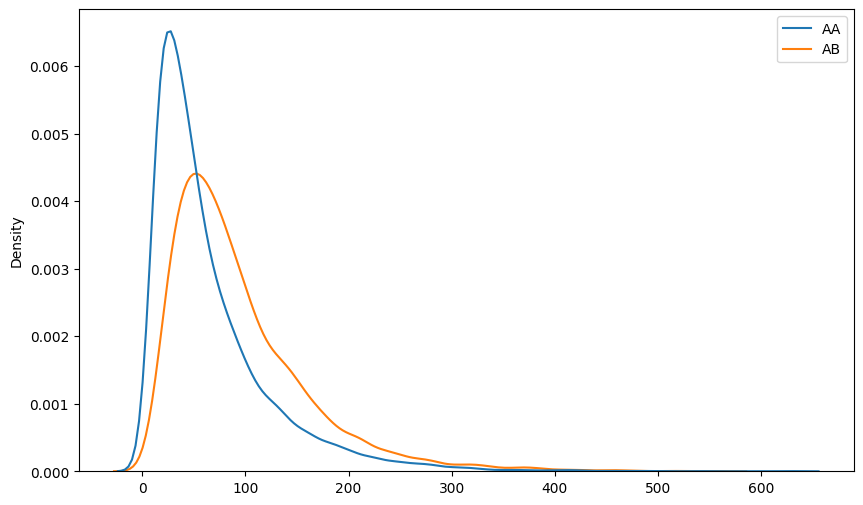

In [12]:
print(F'sample_size = {sample_size}')

for k, v in dict_lengths.items():
    print(f'mean length {k} = {np.mean(v):0.1f}')
sns.kdeplot(data=dict_lengths)
plt.show()

Последовательное тестирование в среднем останавливается раньше время проведеня обычного теста при верности одной из гипотез.

## 2.4. Завышенный эффект
Как будет вести себя тест, если реальный эффект меньше ожидаемого?

Если реальный эффект больше ожидаемого или отрицательный, то тест быстрее отклонит одну из гипотез. А что если мы ожидаем эффект 3%, а он 2% или 1%. Посмотрим как это повлияет на частоту отклонения $H_0$ и продолжительность теста.

In [ ]:
bs_iter = 1000
effects = np.linspace(0, EFFECT, 21)
list_lengths = []
list_results = []

for effect in tqdm(effects):
    lengths = []
    results = []
    array_data_a = np.random.normal(MEAN, STD, (bs_iter, sample_size_))
    array_data_b = np.random.normal(MEAN + effect, STD, (bs_iter, sample_size_))
    for data_a, data_b in zip(array_data_a, array_data_b):
        test_result, length = test_sequential_wald(
            data_a, data_b, pdf_a, pdf_b, ALPHA, BETA
        )
        lengths.append(length)
        results.append(test_result)
    list_lengths.append(lengths)
    list_results.append(results)

In [ ]:
plot_data = [
    [list_lengths, 'length'],
    [list_results, 'part positive']
]

for list_data, label in plot_data:
    array_data = np.array(list_data)
    means = np.mean(array_data, axis=1)
    bs_mean = np.array([
        row[np.random.randint(0, len(row), [1000, len(row)])].mean(axis=1)
        for row in array_data
    ])
    bounds = np.quantile(bs_mean, [0.025, 0.975], axis=1)
    plt.plot(effects, means, label=f'mean {label}')
    plt.fill_between(effects, bounds[0], bounds[1], label=f'95% CI mean {label}', alpha=0.2)
    plt.legend()
    plt.grid()
    plt.xlabel('effect')
    plt.show()

### Итоги
- подглядывание в лоб увеличивает вероятность ошибки первого рода (peeking problem);
- критерий Вальда позволяет контролировать вероятности ошибок при последовательном тестировании;
- последовательное тестирование позволяет в среднем использовать меньше данных.